<a href="https://colab.research.google.com/github/vubanc/BikeAllocationOptimization/blob/main/LSTM_TSForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Time Series Forecasting**

In this notebook a PyTorch-based LSTM model was used to perform time series forecasting of bike trips for a bikesharing program in Fort Smith, Arkansas. The data was collected between the months of May 2022 and August 2023. Time series forecasting was performed on monthly as well as daily levels. The notebook will be updated as new data is collected.

### **Importing Libraries and Datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
import warnings
warnings.filterwarnings("ignore")

In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import r2_score

In [99]:
df = pd.read_csv("/content/drive/MyDrive/Work/Bikesharing/CombinedRentals_AllStations.csv")
df.head(2)

,index,id,user,user_id,user_phone,start_station,start_time,start_time_local,end_station,end_time,end_time_local,kilometers,miles,message_count,type,duration (seconds),rating,device_id,bike_type,Date
0,1,34ac1576-891f-4aca-a570-31db6160fd6f,Dara Ochoa,2112677d-b644-4cb8-866d-58f52b932f76,14792852353,Riverfront Park,2023-08-02 01:09:31.952446+00:00,2023-08-01 19:09:31.952446-06:00,Riverfront Park,2023-08-02 01:10:19.952446+00:00,2023-08-01 19:10:19.952446-06:00,NaN,NaN,130,22,48.0,NaN,74164be4e769c0ff30f08acb19724fa186d89b71913e9b...,Regular Bike,2023-08-01
1,2,dc96b3e6-f607-452b-ad18-79ea96e033d9,Gervon Pennington,79ea58b0-0988-47da-b963-a11a52a94f04,19035560048,Riverfront Park,2023-08-02 00:48:53.349677+00:00,2023-08-01 18:48:53.349677-06:00,Riverfront Park,2023-08-02 01:24:14.349677+00:00,2023-08-01 19:24:14.349677-06:00,4.482,2.78498,41,22,2121.0,NaN,fMV1Kdc8Km,Regular Bike,2023-08-01


### **EDA and Data Preprocesing**

In [100]:
#Data Manipulation (monthly trips)
df.rename(columns={"Date":"date"}, inplace=True)
df["month"] = pd.to_datetime(df["date"]).dt.strftime("%Y-%m")
df_monthlyTrips = df.groupby("month", as_index=False)["id"].count()
df_monthlyTrips.rename(columns={"id":"trip_count"}, inplace=True)
df_monthlyTrips.set_index("month", inplace=True)
df_monthlyTrips.head(2)

,trip_count
month,
2022-05,364
2022-06,316


In [101]:
#Data Manipulation (Daily)
min_date = df.date.min()
max_date = df.date.max()

dates = pd.DataFrame(pd.date_range(start=min_date, end=max_date))
dates.rename(columns={0:"date"}, inplace=True)
df["date"] = pd.to_datetime(df.date)
df = pd.merge(dates, df, how="left", on="date")
df_dailyTrips = pd.DataFrame(df.groupby("date", as_index=True)["id"].count())
df_dailyTrips.rename(columns={"id":"trip_count"}, inplace=True)
df_dailyTrips.head(2)

,trip_count
date,
2022-05-02,2
2022-05-03,14


<Axes: title={'center': 'Daily Trips'}, xlabel='trip_count'>

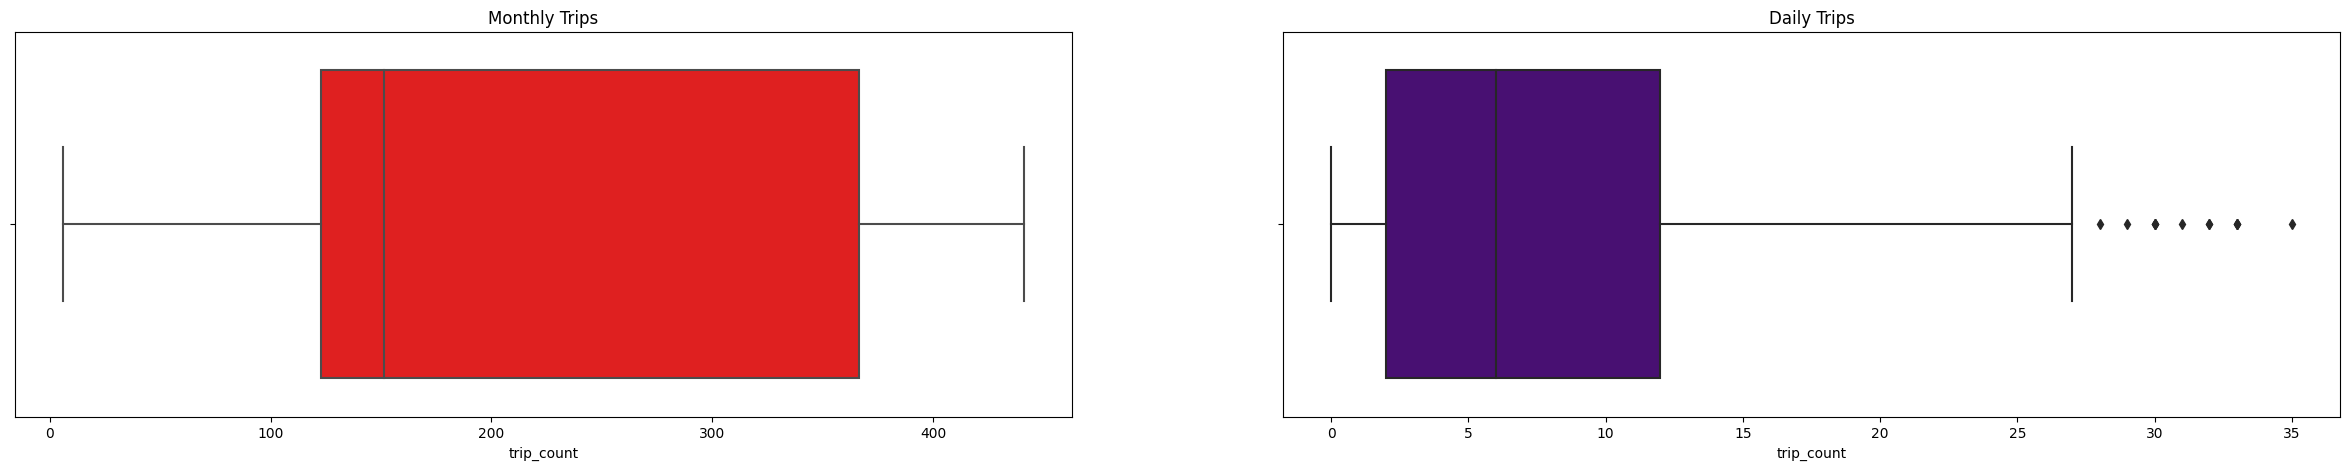

In [102]:
#Distribution of monthly and daily trips
fig, axs = plt.subplots(1,2, figsize=(30,5))
axs[0].set_title("Monthly Trips")
axs[1].set_title("Daily Trips")
sns.boxplot(df_monthlyTrips, x="trip_count", color="red", ax=axs[0])
sns.boxplot(df_dailyTrips, x="trip_count", color="indigo", ax=axs[1])

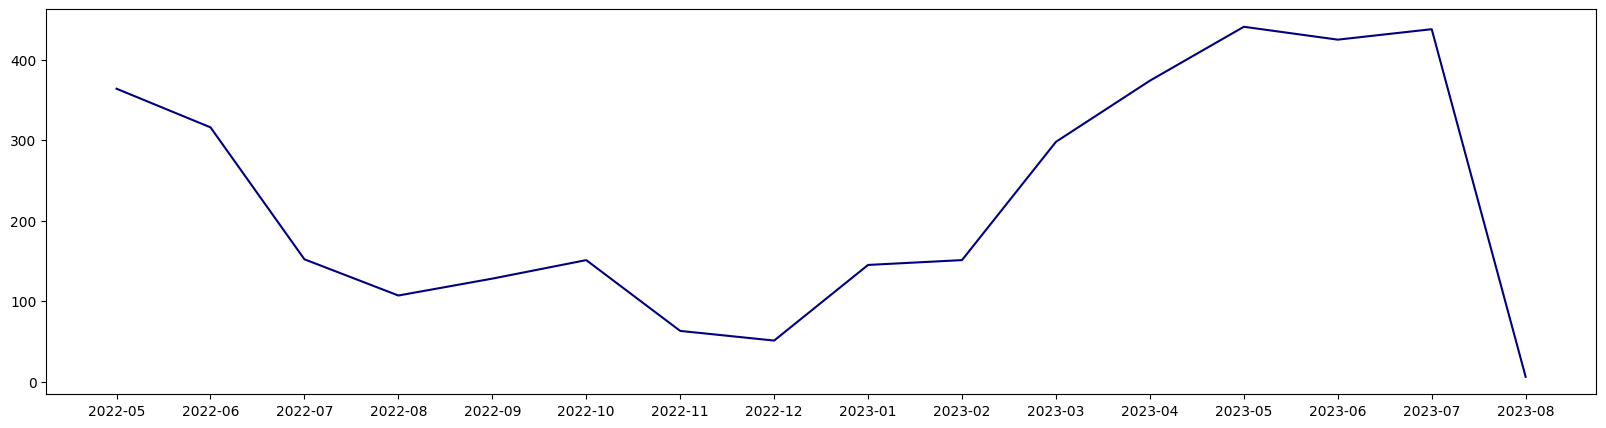

In [103]:
#Monthly Trend
fig, axs = plt.subplots(1,1, figsize=(20,5))
plt.plot(df_monthlyTrips['trip_count'], color="navy")

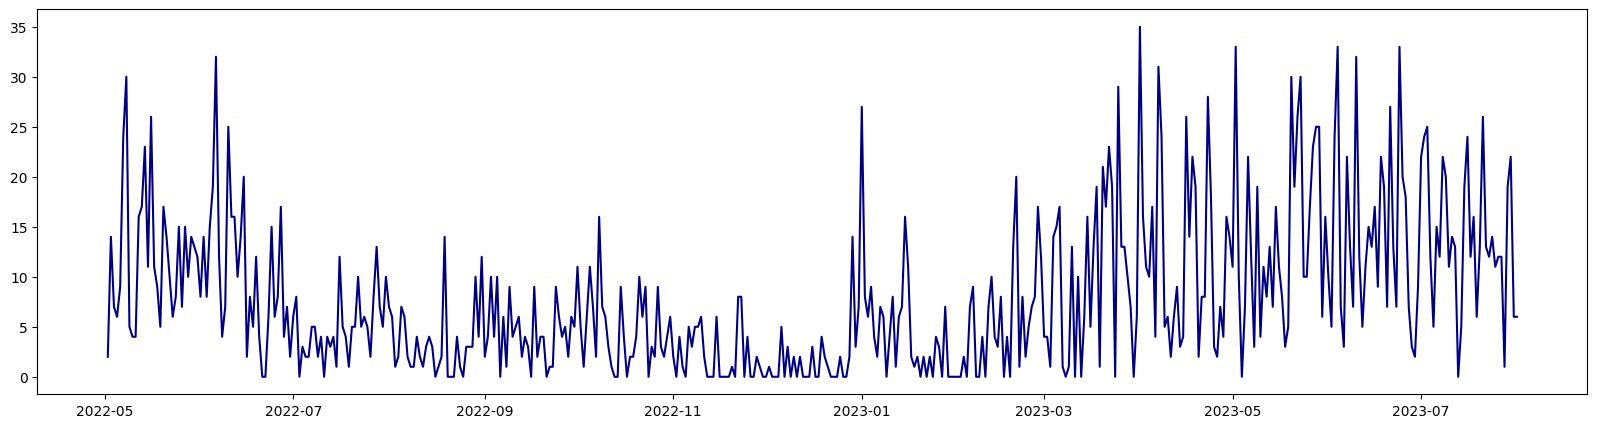

In [104]:
#Daily Trend
fig, axs = plt.subplots(1,1, figsize=(20,5))
plt.plot(df_dailyTrips['trip_count'], color="navy")

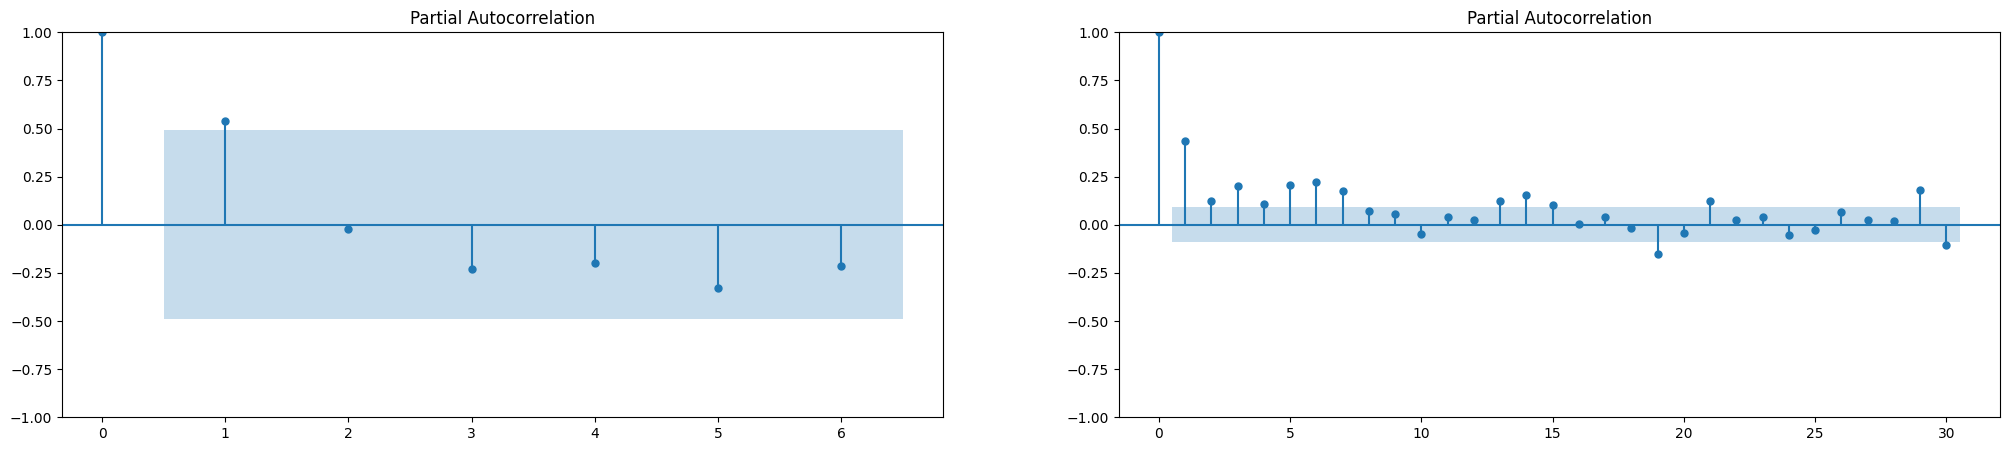

In [105]:
#Partial autocorrelation (monthly and daily)
fig, axs = plt.subplots(1,2, figsize=(25,5))

plot_pacf(df_monthlyTrips, ax=axs[0], lags=6)
plot_pacf(df_dailyTrips, ax=axs[1], lags=30)

plt.show()

In [106]:
#Preparing LSTM input with 7 lags
df_dailyTrips["trip_count"] = df_dailyTrips["trip_count"].astype(float)
df_dailyTrips["t-1"] = df_dailyTrips.trip_count.shift(1)
df_dailyTrips["t-2"] = df_dailyTrips.trip_count.shift(2)
df_dailyTrips["t-3"] = df_dailyTrips.trip_count.shift(3)
df_dailyTrips["t-4"] = df_dailyTrips.trip_count.shift(4)
df_dailyTrips["t-5"] = df_dailyTrips.trip_count.shift(5)
df_dailyTrips["t-6"] = df_dailyTrips.trip_count.shift(6)
df_dailyTrips["t-7"] = df_dailyTrips.trip_count.shift(7)

df_dailyTrips = df_dailyTrips[["t-7", "t-6", "t-5", "t-4", "t-3", "t-2", "t-1", "trip_count"]]
df_dailyTrips = df_dailyTrips[df_dailyTrips.index.strftime("%Y-%m-%d")>="2022-05-09"]
df_dailyTrips.head(10)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,trip_count
date,,,,,,,,
2022-05-09,2.0,14.0,7.0,6.0,9.0,24.0,30.0,5.0
2022-05-10,14.0,7.0,6.0,9.0,24.0,30.0,5.0,4.0
2022-05-11,7.0,6.0,9.0,24.0,30.0,5.0,4.0,4.0
2022-05-12,6.0,9.0,24.0,30.0,5.0,4.0,4.0,16.0
2022-05-13,9.0,24.0,30.0,5.0,4.0,4.0,16.0,17.0
2022-05-14,24.0,30.0,5.0,4.0,4.0,16.0,17.0,23.0
2022-05-15,30.0,5.0,4.0,4.0,16.0,17.0,23.0,11.0
2022-05-16,5.0,4.0,4.0,16.0,17.0,23.0,11.0,26.0
2022-05-17,4.0,4.0,16.0,17.0,23.0,11.0,26.0,11.0


In [109]:
features = np.array(df_dailyTrips[["t-7", "t-6", "t-5", "t-4", "t-3", "t-2", "t-1"]])
labels = np.array(df_dailyTrips[["trip_count"]])

### **Helper Functions**

In [110]:
#Splitting training, validation, and testing data for action labels only
def data_splitter(features, labels):
  split_frac = 0.8
  train_x = features[0:int(split_frac*len(features))]
  train_y = labels[0:int(split_frac*len(features))]
  remaining_x = features[int(split_frac*len(features)):]
  remaining_y = labels[int(split_frac*len(features)):]
  valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
  valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
  test_x = remaining_x[int(len(remaining_x)*0.5):]
  test_y = remaining_y[int(len(remaining_y)*0.5):]

  return train_x, train_y, valid_x, valid_y, test_x, test_y

In [111]:
def data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y):
  train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
  valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
  test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

  batch_size = 520

  train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
  valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
  test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

  return train_loader, valid_loader, test_loader

### **LSTM Class**

In [139]:
class LSTM(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, num_layers, batch_size, learning_rate=0.005, dropout=0.2):
    super(LSTM, self).__init__()
    self.num_layers, self.batch_size, self.hidden_size = num_layers, batch_size, hidden_size
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True, dropout=dropout)
    self.dropout = nn.Dropout(p=0.3)
    self.fc = nn.Linear(input_size, output_size)

    self.loss = nn.MSELoss()
    self.optimizer = torch.optim.Adam(params=self.parameters(), lr=learning_rate)

  def init_hidden(self, batch_size):
    weights = next(self.parameters()).data
    hiddens = (weights.new(self.num_layers, batch_size, self.hidden_size).zero_(),
              weights.new(self.num_layers, batch_size, self.hidden_size).zero_())
    return hiddens

  def forward(self, hiddens, inputs):
    batch_size = inputs.size(0)

    outputs, hn = self.lstm(inputs, hiddens) # outputs -> [batch_size, sequence_length, hidden_size]
    outputs = outputs.contiguous().view(-1, self.hidden_size) # outputs -> [batch_size*seq_length, hidden_size]
    outputs = self.dropout(outputs)
    outputs = self.fc(outputs) # outputs -> [batch_size*seq_length, 1]

    outputs = outputs.view(batch_size, -1) # outputs -> [batch_size, seq_length]
    outputs = outputs[:,-1] # outputs -> [batch_size, 1]

    return outputs, hn

  def train(self, train_loader, valid_loader, epochs):
    for epochs in range(epochs):
      for i, (features, labels) in enumerate(train_loader):
        batch_size = features.size(0)
        hiddens = self.init_hiddens(batch_size)
        outputs, _ = self.forward(features)
        loss = self.loss(outputs.squeeze(), labels.float())

        self.optimizer.zero_grad()
        self.backward()
        nn.utils.clip_grad_norm_(self.parameters(), 5)
        self.optimizer.step()

      if (epoch+1)%epochs==0:
          total_valid_loss = []
          for j,(valid_features, valid_labels) in enumerate(valid_loader):
            batch_size = valid_features.size(0)
            hiddens = self.init_hidden(batch_size)
            valid_outputs,_ = self.forward(hiddens, valid_features)
            valid_loss = self.loss(valid_outputs.squeeze(), valid_labels.float())
            total_valid_loss.append(valid_loss.item())

          print(f"Final Epoch | step:{i} | training loss: {loss} | validation loss: {np.mean(total_valid_loss)}")
    print("Training Complete!")

## **Training**

In [112]:
train_x, train_y, valid_x, valid_y, test_x, test_y = data_splitter(features, labels)
train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y)

In [140]:
model = LSTM(1, 7, 1, 1, 20)
model

LSTM(
  (lstm): LSTM(1, 7, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1, out_features=1, bias=True)
  (loss): MSELoss()
)